# Exercise 3-4

In [79]:
import pysindy as ps
import numpy as np
from numpy.typing import ArrayLike, NDArray
from scipy.fftpack import diff as psdiff
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [80]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "Computer Modern Roman",
    "font.size": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
})

### 3.4.1 KdV Solution

In [81]:
do_load = False

if do_load:
    try:
        KdV_sol = np.load("KdV_solution.npz")
        X1 = KdV_sol["X1"]
        X2 = KdV_sol["X2"]
    except FileNotFoundError:
        KdV_sol = None
else:
    KdV_sol = None

In [82]:
def kdv_exact(x, c, t=0):
    """
    Profile of the exact solution to the KdV for a single soliton.

    From https://scipy-cookbook.readthedocs.io/items/KdV.html
    """
    u = 0.5 * c * np.cosh(0.5 * np.sqrt(c) * (x - c * t))**(-2)
    return u

def kdv(t, u, L):
    """
    Differential equations for the KdV equation.
    
    From From https://scipy-cookbook.readthedocs.io/items/KdV.html
    """
    ux = psdiff(u, period=L)
    uxxx = psdiff(u, period=L, order=3)
    dudt = -6 * u * ux - uxxx
    return dudt

In [ ]:
# Spatial domain
L = 50
N = 256
dx = L / (N - 1.0)
x = np.linspace(0, (1 - 1.0 / N) * L, N)

# Time domain
dt = 0.1
t = np.arange(0, 30 + dt, dt)

# Initial condition
c = 1
u0 = kdv_exact(x - L / 3, c)

In [84]:
if not KdV_sol:
    sol1 = solve_ivp(kdv, (t[0], t[-1]), u0, args=(L,), t_eval=t, dense_output=True, method='Radau')
    X1 = sol1.y.reshape(len(x), len(t))

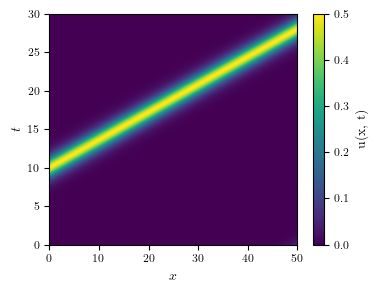

In [85]:
plt.figure(figsize=(4, 3))
plt.imshow(X1, extent=[0, L, t[0], t[-1]], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label="u(x, t)")
plt.xlabel("$x$")
plt.ylabel("$t$")
# plt.title('KdV Solution (c=1)')
plt.savefig("p4fig1.pdf", bbox_inches='tight')
plt.show()

In [86]:
lib_funcs = [
    lambda u: u,
    lambda u: u**2,
]
func_names = [
    lambda u: "u",
    lambda u: "u^2",
]
pde_lib = ps.PDELibrary(
    library_functions=lib_funcs,
    function_names=func_names,
    derivative_order=4,
    spatial_grid=x,
    include_bias=True,
)

model = ps.SINDy(
    feature_library=pde_lib,
    optimizer=ps.STLSQ(threshold=0.01),
    feature_names=["u"]
)
model.fit(X1.reshape(len(x), len(t), 1), t=dt)
model.print()

(u)' = -0.985 u_1 + -0.010 u_111 + -0.089 uu_1


In [87]:
def kdv_model_1(t, u, L):
    """
    Differential equations for the KdV equation.
    """
    ux = psdiff(u, period=L)
    uxxx = psdiff(u, period=L, order=3)
    dudt = -0.985 * ux - 0.010 * uxxx - 0.089 * u * ux
    return dudt

test_sol1 = solve_ivp(kdv_model_1, (t[0], t[-1]), u0, args=(L,), t_eval=t, dense_output=True, method='Radau')
X1_model = sol1.y.reshape(len(x), len(t))

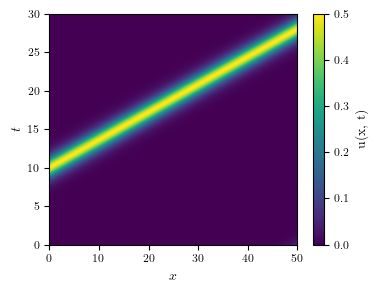

In [88]:
plt.figure(figsize=(4, 3))
plt.imshow(X1_model, extent=[0, L, t[0], t[-1]], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label="u(x, t)")
plt.xlabel("$x$")
plt.ylabel("$t$")
# plt.title('KdV SINDy Model')
plt.savefig("p4afig2.pdf", bbox_inches='tight')
plt.show()

### 3.4.2

In [89]:
c = 4
u0 = kdv_exact(x - L / 3, c)  # Single soliton, offset for periodicity

In [90]:
if not KdV_sol:
    sol2 = solve_ivp(kdv, (t[0], t[-1]), u0, args=(L,), t_eval=t, dense_output=True, method='Radau')
    X2 = sol2.y.reshape(len(x), len(t))

In [91]:
X = np.concatenate((X1, X2), axis=0)

In [92]:
if not KdV_sol:
    np.save("KdV_solution.npz", {"X1": X1, "X2": X2}, allow_pickle=True)

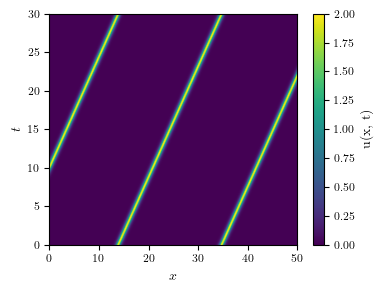

In [93]:
plt.figure(figsize=(4, 3))
plt.imshow(X2, extent=[0, L, t[0], t[-1]], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label="u(x, t)")
plt.xlabel("$x$")
plt.ylabel("$t$")
# plt.title('KdV Solution (c=4)')
plt.savefig("p4fig3.pdf", bbox_inches='tight')
plt.show()

In [94]:
lib_funcs = [
    lambda u: u,
    lambda u: u**2,
]
func_names = [
    lambda u: "u",
    lambda u: "u^2",
]
pde_lib = ps.PDELibrary(
    library_functions=lib_funcs,
    function_names=func_names,
    derivative_order=4,
    spatial_grid=x,
    include_bias=True,
)

model = ps.SINDy(
    feature_library=pde_lib,
    optimizer=ps.STLSQ(threshold=1),
    feature_names=["u"]
)
model.fit(X.reshape(len(x), 2*len(t), 1), t=dt)
model.print()

(u)' = -3.782 uu_1 + 1.596 u^2u_1


In [95]:
def kdv_model_2(t, u, L):
    """
    Differential equations for the KdV equation.
    """
    ux = psdiff(u, period=L)
    uxxx = psdiff(u, period=L, order=3)
    dudt = - 1.183 * uxxx -6.192 * u * ux
    return dudt

test_sol1 = solve_ivp(kdv, (t[0], t[-1]), u0, args=(L,), t_eval=t, dense_output=True, method='Radau')
X2_model = sol2.y.reshape(len(x), len(t))
X_model = np.concatenate((X1_model, X2_model), axis=0)

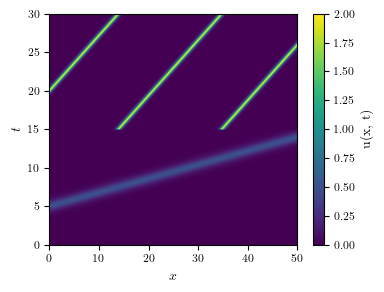

In [96]:
plt.figure(figsize=(4, 3))
plt.imshow(X_model, extent=[0, L, t[0], t[-1]], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label="u(x, t)")
plt.xlabel("$x$")
plt.ylabel("$t$")
# plt.title('KdV SINDy model using concatenateed data')
plt.savefig("p4fig2.pdf", bbox_inches='tight')
plt.show()